In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [2]:
df = pd.read_csv("csvs/merged-df.csv")

In [3]:
# Setting up different sets of columns to easily try out different sets of variables

sch_indep = ["grade9", "only_hs"]
per_indep = ["ell_percent", "sped_percent","asian_per",
             "black_per", "hispanic_per"]#,"white_per"]
num_indep = ["ell_num", "sped_num", "asian_num",
             "black_num","hispanic_num", "white_num"]
num_inv=[]
per_sqr=[]

# setting up inverse variables
for coln in num_indep:
    num_inv.append("inv_"+coln)
    df["inv_"+coln] = 1/(df[coln]+1)

# setting up squared variables
for colp in per_indep:
    df[colp]=df[colp]/100
    df["sqr_"+colp]=df[colp]**2
    per_sqr.append("sqr_"+colp)

In [4]:
# dropping data where there are more grads than students in the class
# either due to error or large transfer student sizes potentially.
display(df.shape)
df["grad_per"]=df["Toal Grads #"]/df["grade9"]*100
errordf = df[df["grad_per"]>=100]
df=df[df["grad_per"]<=100]
display(df.shape)

(2736, 60)

(2566, 61)

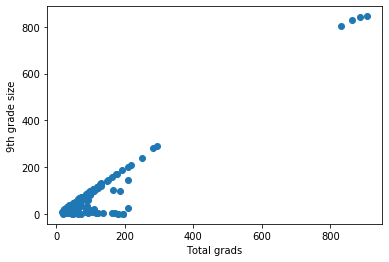

In [5]:
# a look at samples where grads size is larger than class size
errordf.describe()
plt.scatter(errordf["Toal Grads #"],errordf["grade9"])
plt.xlabel("Total grads")
plt.ylabel("9th grade size")
plt.savefig("graphs/error-data.png")

In [6]:
df.describe()

,Unnamed: 0,schoolyear,Cohort #,Toal Grads #,% of cohort,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,has_junior_high,total_students,total_elem,total_kg,has_kg,has_elem,total_junior_high,only_hs,levels_not_hs,inv_ell_num,inv_sped_num,inv_asian_num,inv_black_num,inv_hispanic_num,inv_white_num,sqr_ell_percent,sqr_sped_percent,sqr_asian_per,sqr_black_per,sqr_hispanic_per,grad_per
count,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.00000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000
mean,1381.466875,2008.164848,188.222136,144.673422,77.901832,33.212646,33.174591,827.199922,0.019486,0.469213,0.464926,0.467264,0.439205,0.455183,0.423227,11.775526,13.921668,13.787607,262.501559,226.705378,157.121200,138.64809,88.424006,0.116069,96.574435,0.125314,120.169525,0.083484,272.538581,0.391795,317.051832,0.431856,104.917381,7.676734,416.966485,49.051676,410.233048,50.948636,0.195635,827.199532,2.249805,0.488698,0.006235,0.010912,39.484801,0.799688,0.212783,0.099689,0.058647,0.150065,0.020529,0.009278,0.169721,0.044825,0.020017,0.022992,0.214842,0.241340,59.468728
std,782.266301,1.983093,221.476236,180.329874,15.075954,34.141560,37.332212,941.381390,0.575330,6.490571,6.408703,6.399645,6.063665,6.198231,5.855984,31.013213,33.945842,34.222294,313.247771,279.250376,201.734894,191.54543,159.025657,0.177103,110.749858,0.065688,323.447059,0.126605,329.817759,0.247715,376.472404,0.234227,292.041064,12.987077,504.214534,13.300857,465.780599,13.300765,0.396766,941.381317,30.481918,6.556671,0.078733,0.103909,96.341633,0.400312,0.451042,0.193947,0.156775,0.218853,0.097587,0.012898,0.225153,0.149531,0.018277,0.068209,0.238910,0.214446,20.218033
min,0.000000,2005.000000,6.000000,0.000000,0.000000,0.000000,0.000000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.024000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000705,0.001330,0.000311,0.000260,0.000344,0.000314,0.000000,0.000000,0.000000,0.000000,0.000576,0.000000
25%,712.250000,2006.000000,82.000000,60.000000,69.100000,0.000000,0.000000,338.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,101.000000,88.000000,61.000000,43.00000,11.000000,0.026000,30.000000,0.084000,4.000000,0.012000,93.000000,0.217250,98.000000,0.210000,3.000000,0.900000,154.000000,43.700000,166.000000,45.600000,0.000000,338.250000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.013333,0.009639,0.016462,0.002994,0.002894,0.020408,0.000676,0.007056,0.000144,0.047198,0.044100,45.981673
50%,1376.500000,2008.000000,102.000000,78.000000,79.000000,23.950000,0.000000,450.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,133.000000,117.000000,88.000000,77.00000,30.000000,0.061000,62.000000,0.128000,13.000000,0.027000,161.000000,0.340000,209.000000,0.464000,9.000000,2.000000,221.000000,49.200000,239.000000,50.800000,0.000000,4

In [7]:
# you can remove the #s but the non per_sqr result in overfitting/higher pvalues
independents = per_indep#+per_sqr#+sch_indep+num_inv
x_mega_train, x_holdout, y_mega_train, y_holdout = train_test_split(
                                                    df[independents],
                                                    df["grad_per"],
                                                    test_size=0.1)
# before having a final model we subsplit our data to not leak from the final test set
"""x_train, x_test, y_train, y_test = train_test_split(x_mega_train,
                                                    y_mega_train,
                                                    test_size=0.2)"""

In [8]:
# scaling data just for the ols regression - we go back to using the megatrain for
# the polynomializing to prevent squaring negatives
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(x_mega_train)

#transform the x data
x_train_s = pd.DataFrame(data=scaler.transform(x_mega_train), columns=x_mega_train.columns)
x_test_s = pd.DataFrame(data=scaler.transform(x_holdout), columns=x_holdout.columns)




In [9]:
lm_grad = LinearRegression()

lm_grad.fit(x_train_s,y_mega_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
# capping predictions at 100 - we don't do this for the final regression which
# could've further improved our rmse
basic_y_prediction = lm_grad.predict(x_test_s)
basic_y_prediction = list(map(lambda x: x if x<100 else 100, basic_y_prediction))
basic_rmse = np.sqrt(metrics.mean_squared_error(y_holdout, basic_y_prediction))
print("basic rmse", basic_rmse)

basic rmse 16.04731127015146


In [45]:
# checking the rmse of just predicting the training set's mean
x_test["null"] = y_mega_train.mean()
basic_rmse = np.sqrt(metrics.mean_squared_error(y_test, x_test["null"]))
print("null mean prediction rmse", basic_rmse)

basic rmse 20.182845797205125


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
# a quick look at our prediction - it looks like it predicts pretty close to the mean
display(basic_y_prediction)

[58.86582307500037,
 57.199077289451225,
 51.44159065521576,
 49.74399102978003,
 70.21644543982626,
 46.00708826601527,
 61.00403888708973,
 62.928556631194375,
 58.30195695394848,
 67.8194785206156,
 62.73598502379787,
 98.79938087913271,
 63.73544915255891,
 47.28404844956965,
 53.815772513354695,
 67.50680576913174,
 52.54009162090507,
 49.78765287636264,
 69.82885337991809,
 55.996111226380165,
 82.94489343200775,
 51.39452139854325,
 69.3618214478935,
 47.15162816729164,
 52.43416049272739,
 53.29487610706241,
 62.487266127999824,
 63.326692131570006,
 69.28221178192267,
 50.69668004857407,
 77.34588384712849,
 47.565510712388,
 61.397134569279174,
 66.43233958733956,
 59.33795924938324,
 64.1760861772675,
 50.51620292538895,
 87.67067710959643,
 47.475245112227405,
 75.59215621962733,
 53.54973569182773,
 51.14153385829373,
 65.2423776673782,
 57.60225194117068,
 57.65789462593321,
 41.94479128952032,
 72.78933974182573,
 59.73942517724771,
 45.61545101808579,
 57.05446992812860

In [13]:
# a look at coef sizes - pretty small
lm_grad.coef_

array([-3.39137891, -7.39508877, -1.65399199, -9.89232856, -7.1559585 ])

In [48]:
# this is the same model but done with ols to look at r2 and coefficients.
# its worth noting that high p values aren't inherently bad before doing
# polynomialization bc the polynomial features may improve accuracy 
# of the original features.
from statsmodels.formula.api import ols
colnames = "+".join(filter(lambda x: x not in ["grad_per",
                                               #"lat","long"
                                              ], x_train_s.columns))

full_train=pd.concat([y_mega_train,x_train_s],axis=1).rename({0:"grad_per"},axis=1)
olsstr = "grad_per~"+colnames
lr_model = ols(formula=olsstr, data=full_train).fit()
#full_train

lr_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               grad_per   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.401
Date:                Mon, 14 Sep 2020   Prob (F-statistic):              0.221
Time:                        11:50:06   Log-Likelihood:                -8612.8
No. Observations:                1953   AIC:                         1.724e+04
Df Residuals:                    1947   BIC:                         1.727e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       58.2730      0.452    129.060      0.000      57.387      59.158
ell_percent     -0.5383      0.533     -1.011      0.312      -1.583       0.506
sped_percent     0.9997      0.524      1.909      0.056      -0.027       2.027
asian_per        0.3135      0.813      0.386      0.700      -1.281       1.908
black_per        0.0854      0.947      0.090      0.928      -1.771       1.942
hispanic_per     0.3673      0.978      0.376      0.707      -1.550       2.285
==============================================================================
Omnibus:                       20.586   Durbin-Watson:                   0.681
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.577
Skew:                          -0.091   Prob(JB):                     0.000683
Kurtosis:                       2.617   Cond. No.                         4.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# this is slightly negative compared to the other regression bc we didn't cap for this one.
basic_model_pred = lr_model.predict(x_test_s)
from sklearn.metrics import r2_score
r2_score(y_holdout,basic_model_pred)


-0.044816522444711016

In [17]:
# taking a look at vif before polynomializing - looks pretty good (after dropping white
# percentage).

from statsmodels.stats.outliers_influence import variance_inflation_factor
viffactor = [variance_inflation_factor(x_train_s.values, i) for i in range(x_train_s.shape[1])]

vif = pd.DataFrame()
vif["VIF Factor"] = viffactor
#[variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]
vif["features"] = x_train_s.columns
vif=vif.round(1).sort_values("VIF Factor",ascending=False)
vif

,VIF Factor,features
4,4.9,hispanic_per
3,4.7,black_per
2,3.4,asian_per
0,1.5,ell_percent
1,1.3,sped_percent


In [18]:
# polynomializing - nothing complicated here
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(x_mega_train)
poly2_columns = poly_2.get_feature_names(x_mega_train.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()


,ell_percent,sped_percent,asian_per,black_per,hispanic_per,ell_percent^2,ell_percent sped_percent,ell_percent asian_per,ell_percent black_per,ell_percent hispanic_per,sped_percent^2,sped_percent asian_per,sped_percent black_per,sped_percent hispanic_per,asian_per^2,asian_per black_per,asian_per hispanic_per,black_per^2,black_per hispanic_per,hispanic_per^2
0,0.063,0.093,0.040,0.256,0.623,0.003969,0.005859,0.002520,0.016128,0.039249,0.008649,0.003720,0.023808,0.057939,0.001600,0.010240,0.024920,0.065536,0.159488,0.388129
1,0.038,0.085,0.019,0.303,0.580,0.001444,0.003230,0.000722,0.011514,0.022040,0.007225,0.001615,0.025755,0.049300,0.000361,0.005757,0.011020,0.091809,0.175740,0.336400
2,0.079,0.118,0.018,0.333,0.621,0.006241,0.009322,0.001422,0.026307,0.049059,0.013924,0.002124,0.039294,0.073278,0.000324,0.005994,0.011178,0.110889,0.206793,0.385641
3,0.098,0.171,0.149,0.179,0.571,0.009604,0.016758,0.014602,0.017542,0.055958,0.029241,0.025479,0.030609,0.097641,0.022201,0.026671,0.085079,0.032041,0.102209,0.326041
4,0.176,0.131,0.029,0.258,0.696,0.030976,0.023056,0.005104,0.045408,0.122496,0.017161,0.003799,0.033798,0.091176,0.000841,0.007482,0.020184,0.066564,0.179568,0.484416


In [19]:
# polynomializing the test set as well
test_poly2_data = poly_2.fit_transform(x_holdout)
test_poly2_columns = poly_2.get_feature_names(x_holdout.columns)
test_poly2_df = pd.DataFrame(test_poly2_data, columns=test_poly2_columns)

In [20]:
# taking a look at vif after polynomializing - its relatively high but
# i don't think its inherently too bad - especially given that we rfe
# out the features that have negative impact on the model
from statsmodels.stats.outliers_influence import variance_inflation_factor
viffactor = [variance_inflation_factor(df_poly2.values, i) for i in range(df_poly2.shape[1])]

vif = pd.DataFrame()
vif["VIF Factor"] = viffactor
#[variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]
vif["features"] = df_poly2.columns
vif=vif.round(1).sort_values("VIF Factor",ascending=False)
vif = vif[vif["VIF Factor"]<50]
vif_features = vif["features"]
x_train_vif = df_poly2[vif_features]
vif

,VIF Factor,features
7,47.1,ell_percent asian_per
14,44.7,asian_per^2
5,42.5,ell_percent^2
16,37.2,asian_per hispanic_per
8,33.2,ell_percent black_per
10,26.9,sped_percent^2
15,15.7,asian_per black_per
6,12.9,ell_percent sped_percent
11,11.5,sped_percent asian_per


In [21]:
#basic rfecv
from sklearn.feature_selection import RFECV
ols = LinearRegression()

selector = RFECV(estimator=ols, min_features_to_select=5, step=1, cv=5,
                 scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
selector.fit(df_poly2, y_mega_train)


Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.


RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=5, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=2)

In [22]:
selected_rfe = df_poly2.columns[selector.support_]
removed_rfe = df_poly2.columns[~selector.support_]

In [23]:
# testing rfe 
lm_rfe = LinearRegression()

lm_rfe = lm_rfe.fit(df_poly2[selected_rfe], y_mega_train)

y_rfe = lm_rfe.predict(test_poly2_df[selected_rfe])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_holdout, y_rfe))


print('holdout predictions rmse using rfe:' , trainRFE_rmse)



holdout predicting rmse using rfe: 15.601546241146133


In [24]:
lm_rfe.coef_

array([-176.2176361 , -162.79133708,  -55.16942184,  -92.96864815,
        146.69645318,  111.5592015 ,   45.75472495,   92.02923871,
        334.40545429,  171.76540007,  -78.7190498 ,   70.21035591,
         94.30893659,  -44.05706745,   68.83968275,  -23.59304263])

In [25]:
selected_rfe

Index(['ell_percent', 'sped_percent', 'asian_per', 'black_per',
       'ell_percent^2', 'ell_percent sped_percent', 'ell_percent asian_per',
       'ell_percent black_per', 'sped_percent^2', 'sped_percent asian_per',
       'sped_percent black_per', 'asian_per^2', 'asian_per black_per',
       'asian_per hispanic_per', 'black_per^2', 'black_per hispanic_per'],
      dtype='object')

In [26]:
rfe_coef_df = pd.DataFrame()

In [27]:
rfe_coef_df["feature"] = selected_rfe
rfe_coef_df["coefficient"] = lm_rfe.coef_

In [28]:
# heres a look at our feature weighting
rfe_coef_df

,feature,coefficient
0,ell_percent,-176.217636
1,sped_percent,-162.791337
2,asian_per,-55.169422
3,black_per,-92.968648
4,ell_percent^2,146.696453
5,ell_percent sped_percent,111.559202
6,ell_percent asian_per,45.754725
7,ell_percent black_per,92.029239
8,sped_percent^2,334.405454
9,sped_percent asian_per,171.765400


In [29]:
# comparing 90% black student body to 60% black student body
black_per_term = rfe_coef_df[rfe_coef_df["feature"]=="black_per"]#*.2#["coefficient"]
black2_term = rfe_coef_df[rfe_coef_df["feature"]=="black_per^2"]#*.2**2#["coefficient"]
print(sum(.9*black_per_term["coefficient"],.9**2*black2_term["coefficient"]))
print(.9*black_per_term["coefficient"])


14   -27.91164
Name: coefficient, dtype: float64
3   -83.671783
Name: coefficient, dtype: float64


In [30]:
black_per_term = rfe_coef_df[rfe_coef_df["feature"]=="black_per"]#*.2#["coefficient"]
black2_term = rfe_coef_df[rfe_coef_df["feature"]=="black_per^2"]#*.2**2#["coefficient"]
print(sum(.6*black_per_term["coefficient"],.6**2*black2_term["coefficient"]))
print(.6*black_per_term["coefficient"])

14   -30.998903
Name: coefficient, dtype: float64
3   -55.781189
Name: coefficient, dtype: float64


In [31]:
# r2 score - surprisingly good !!
from sklearn.metrics import r2_score
r2_score(y_holdout,y_rfe)

0.3572858282620872

Below is just a look at the shape of the data to get a sense of what our data looked like

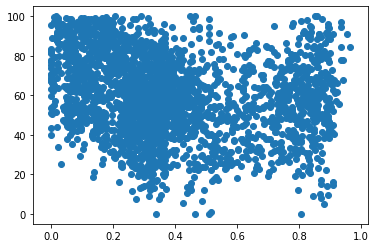

In [32]:
plt.scatter(df["black_per"],df["grad_per"])


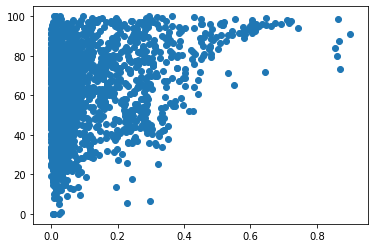

In [33]:
plt.scatter(df["asian_per"],df["grad_per"])

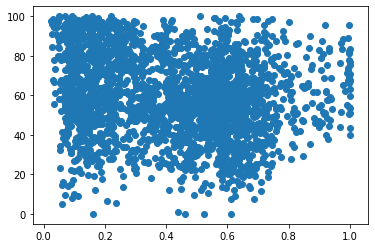

In [34]:
plt.scatter(df["hispanic_per"],df["grad_per"])

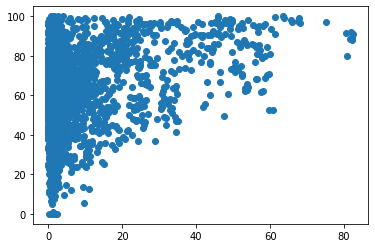

In [35]:
plt.scatter(df["white_per"],df["grad_per"])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


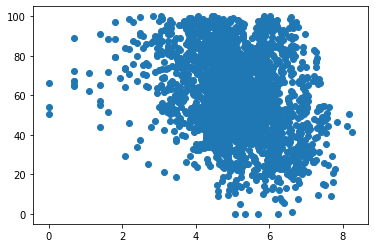

In [36]:
plt.scatter(np.log(df["black_num"]),df["grad_per"])


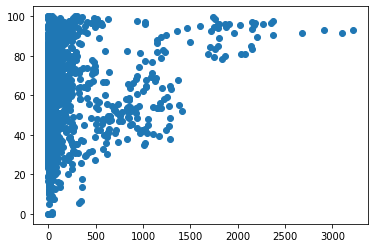

In [37]:
plt.scatter(df["asian_num"],df["grad_per"])

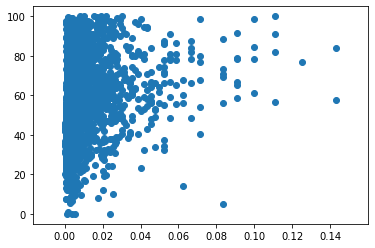

In [38]:
plt.scatter(1/df["hispanic_num"],df["grad_per"])

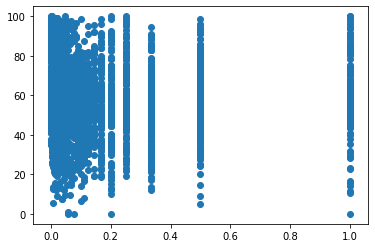

In [39]:
plt.scatter(1/df["white_num"],df["grad_per"])

In [40]:
df["white_num"].nunique()

431

In [41]:
df["black_num"].nunique()
df["hispanic_num"].nunique()

794

In [42]:
df[df["white_num"]<5]

,Unnamed: 0,DBN,schoolyear,Cohort #,Toal Grads #,% of cohort,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,has_junior_high,total_students,true,total_elem,total_kg,has_kg,has_elem,total_junior_high,only_hs,levels_not_hs,inv_ell_num,inv_sped_num,inv_asian_num,inv_black_num,inv_hispanic_num,inv_white_num,sqr_ell_percent,sqr_sped_percent,sqr_asian_per,sqr_black_per,sqr_hispanic_per,grad_per
93,93,02M303,2005,105,58,65.2,60.0,0.0,114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,20.0,0.175,17.0,0.149,3,0.026,29,0.254,73,0.640,4,3.5,72.0,63.2,42.0,36.8,0,114.0,True,0.0,0.0,0,0,0.0,1,0,0.047619,0.055556,0.250000,0.033333,0.013514,0.200000,0.030625,0.022201,0.000676,0.064516,0.409600,50.877193
97,97,02M303,2009,98,66,68.0,0.0,85.9,401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,227.0,85.0,69.0,20.0,59.0,0.147,82.0,0.204,8,0.020,125,0.312,261,0.651,3,0.7,202.0,50.4,199.0,49.6,0,401.0,True,0.0,0.0,0,0,0.0,1,0,0.016667,0.012048,0.111111,0.007937,0.003817,0.250000,0.021609,0.041616,0.000400,0.097344,0.423801,29.074890
107,107,02M308,2005,67,56,86.2,60.0,0.0,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.0,0.0,0.0,0.0,1.0,0.012,14.0,0.169,7,0.084,39,0.470,30,0.361,3,3.6,37.0,44.6,46.0,55.4,0,83.0,True,0.0,0.0,0,0,0.0,1,0,0.500000,0.066667,0.125000,0.025000,0.032258,0.250000,0.000144,0.028561,0.007056,0.220900,0.130321,67.469880
121,121,02M316,2005,77,59,81.7,60.0,0.0,107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,0.0,0.0,1.0,0.009,11.0,0.103,1,0.009,26,0.243,68,0.636,3,2.8,0.0,0.0,107.0,100.0,0,107.0,True,0.0,0.0,0,0,0.0,1,0,0.500000,0.083333,0.500000,0.037037,0.014493,0.250000,0.000081,0.010609,0.000081,0.059049,0.404496,55.140187
122,122,02M316,2006,74,60,82.2,73.8,0.0,206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.0,93.0,0.0,0.0,8.0,0.039,17.0,0.083,7,0.034,72,0.350,111,0.539,3,1.5,0.0,0.0,206.0,100.0,0,206.0,True,0.0,0.0,0,0,0.0,1,0,0.111111,0.055556,0.125000,0.013699,0.008929,0.250000,0.001521,0.006889,0.001156,0.122500,0.290521,53.097345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,2731,32K556,2007,138,83,65.4,86.6,0.0,458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,174.0,121.0,82.0,81.0,108.0,0.236,53.0,0.116,6,0.013,76,0.166,373,0.814,2,0.4,192.0,41.9,266.0,58.1,0,458.0,True,0.0,0.0,0,0,0.0,1,0,0.009174,0.018519,0.142857,0.012987,0.002674,0.333333,0.055696,0.013456,0.000169,0.027556,0.662596,47.701149
2732,2732,32K556,2008,110,60,56.1,86.4,0.0,489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176.0,144.0,80.0,89.0,100.0,0.204,75.0,0.153,6,0.012,78,0.160,400,0.818,4,0.8,225.0,46.0,264.0,54.0,0,489.0,True,0.0,0.0,0,0,0.0,1,0,0.009901,0.013158,0.142857,0.012658,0.002494,0.200000,0.041616,0.023409,0.000144,0.025600,0.669124,34.090909
2733,2733,32K556,2009,110,80,76.2,0.0,94.4,481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155.0,133.0,108.0,85.0,102.0,0.212,82.0,0.170,5,0.010,81,0.168,391,0.813,2,0.4,245.0,50.9,236.0,49.1,0,481.0,True,0.0,0.0,0,0,0.0,1,0,0.009709,0.012048,0.166667,0.012195,0.002551,0.333333,0.044944,0.028900,0.000100,0.028224,0.660969,51.612903
2734,2734,32K556,2010,110,82,81.2,0.0,96.7,500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.0,109.0,111.0,144.0,101.0,0.202,88.0,0.176,3,0.006,92,0.184,402,0.804,1,0.2,270.0,54.0,230.0,46.0,0,500.0,True,0.0,0.0,0,0,0.0,1,0,0.009804,0.011236,0.250000,0.010753,0.002481,0.500000,0.040804,0.030976,0.000036,0.033856,0.646416,60.294118


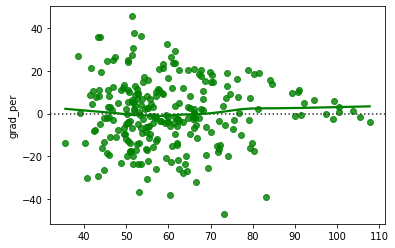

In [43]:
sns.residplot(y_rfe, y_holdout, lowess=True, color="g")

In [44]:
y_holdout.describe()

count    257.000000
mean      59.366998
std       19.498683
min       12.155963
25%       45.660036
50%       57.692308
75%       72.592593
max       99.298246
Name: grad_per, dtype: float64